# EDA Analysis

### Business Scenario:

AAVAIL is seeking revenue projections to help stabilize staffing and budget projections which will have a beneficial ripple effect throughout the company. Information from invoice logs is investigated to determine future revenue.

### Hypothesis

The question we seek to answer is whether there is a relationship between invoice data and future revenue projections.

Null Hypothesis: There is no relation between invoice data and the target revenue of 30 days in the future
Alternative Hypothesis: There is a relationship between invoice data and the target revenue of 30 days in the future.

In [1]:
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import timedelta, date
import numpy as np
import seaborn as sns
import visualisation as vis

import data_ingestion as di
plt.style.use('seaborn')

%matplotlib inline

SMALL_SIZE = 8
MEDIUM_SIZE = 10
LARGE_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

### Ingest Data

In [2]:
trainingData = "cs-train"
df = di.createDataFrame(trainingData)
df.head(10)

read from cs-train.


/home/jovyan/data_ingestion.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df['invoice'] = df['invoice'].str.replace('\D+', '')


read from cs-train.


/home/jovyan/data_ingestion.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df['invoice'] = df['invoice'].str.replace('\D+', '')


,country,customer_id,invoice,price,stream_id,times_viewed,year,month,day,invoice_date
0,United Kingdom,13085.0,489434,6.95,85048,12,2017,11,28,2017-11-28
1,United Kingdom,NaN,489597,8.65,22130,1,2017,11,28,2017-11-28
2,United Kingdom,NaN,489597,1.70,22132,6,2017,11,28,2017-11-28
3,United Kingdom,NaN,489597,1.70,22133,4,2017,11,28,2017-11-28
4,United Kingdom,NaN,489597,0.87,22134,1,2017,11,28,2017-11-28
5,United Kingdom,NaN,489597,0.87,22135,1,2017,11,28,2017-11-28
6,United Kingdom,NaN,489597,11.26,22138,3,2017,11,28,2017-11-28
7,United Kingdom,NaN,489597,11.26,22139,2,2017,11,28,2017-11-28
8,United Kingdom,NaN,489597,4.30,22141,6,2017,11,28,2017-11-28
9,United Kingdom,NaN,489597,3.43,22142,2,2017,11,28,2017-11-28


### Missing data analysis

We observe only customer_id involves missing data. As there is unevenly missing customer_id information and it is difficult to fit into a time series dataframe we end up dropping the column

In [3]:
print("Missing data")
print(df.isnull().sum(axis = 0))

Missing data
country              0
customer_id     189282
invoice              0
price                0
stream_id            0
times_viewed         0
year                 0
month                0
day                  0
invoice_date         0
dtype: int64


#### Comparison of missing data

We observe that data is missing not at random with all invoices from HK missing customer ids.

In [4]:
df['missing_customer'] = df.isnull().customer_id
missingCustomers = df.groupby(['country']).sum()['missing_customer'].to_frame()
missingCustomers['totalRows'] = df.groupby(['country']).size()
missingCustomers['percentLost'] = round(missingCustomers['missing_customer']/missingCustomers['totalRows'] * 100,2)

Text(0, 0.5, 'Percentage of lost customer ids')

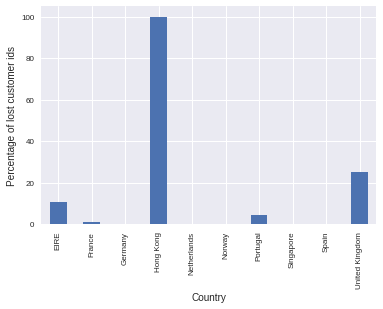

In [5]:
missingCustomers['percentLost'].plot.bar()
plt.xlabel('Country')
plt.ylabel('Percentage of lost customer ids')

## Revenue per country

We observe a highly unbalanced distribution with nearly all revenue within the United Kingdom.

Text(0, 0.5, 'Total revenue ($)')

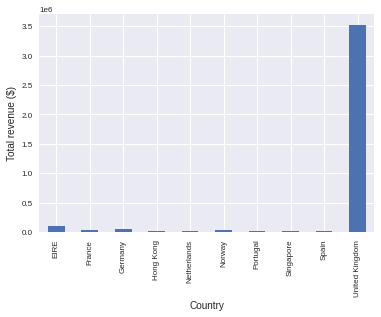

In [6]:
df.groupby(['country'])['price'].sum().plot.bar() #.sort_values(by='price', ascending=False)
plt.xlabel('Country')
plt.ylabel('Total revenue ($)')


We observe that revenue trends are to some degree independent by country. Revenue projects are highly biased by UK

Text(0, 0.5, 'Total revenue ($)')

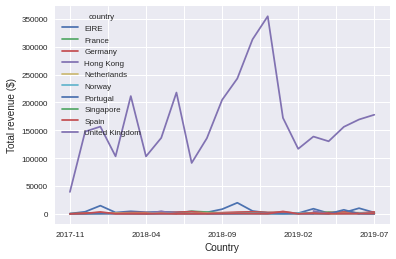

In [7]:
by_month = pd.pivot_table(df, index=df.invoice_date.dt.strftime('%Y-%m'), columns=df.country, values='price', aggfunc='sum')
by_month.plot()
plt.xlabel('Country')
plt.ylabel('Total revenue ($)')

We see that the data is sporadic with different countries showing 'bursts'. Hong Kong, Norway and Singapore are the most extreme with large periods of gaps.

## Time Series Analysis

We convert data into a time series to enable us to explore relationship between aggregated data.

In [8]:
ts = di.convertToTimeSeries(df)
ts.head(10)

,revenue,times_viewed,interactions,unique_invoices,unique_streams
2017-11-28,14139.14,14948,3203,162,1342
2017-11-29,13396.92,14135,3271,130,1397
2017-11-30,13250.07,15560,2980,149,1331
2017-12-01,9517.35,12180,2515,105,1246
2017-12-02,1263.28,3101,370,31,263
2017-12-03,6354.69,8421,1924,89,973
2017-12-04,13023.36,12350,2826,121,1334
2017-12-05,9358.97,12474,2419,167,1190
2017-12-06,11263.69,10493,2467,112,1307
2017-12-07,10816.89,11688,2430,119,1197


Observe frequencies of interactions

Text(0, 0.5, 'Interactions')

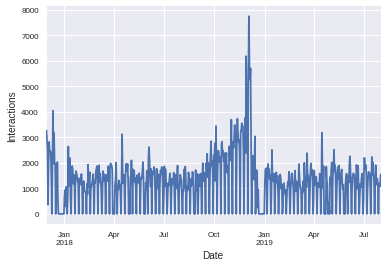

In [9]:
ts.interactions.plot()

plt.xlabel('Date')
plt.ylabel('Interactions')

### Feature Engineering

We observe that revenue & other features appear are non-constant. We perform further feature engineering to allow us to investigate a relationship to investigate projected growth

In [10]:
tts = di.featureEngineerTs(ts, True)
tts.head(20)

,target_revenue,past_7_revenue,past_31_revenue,past_60_revenue,past_150_revenue,past_30_mean_interactions,past_150_mean_interactions,past_30_mean_views,past_150_mean_views,past_30_mean_invoices,past_150_mean_invoices,past_30_mean_streams,past_150_mean_streams
2017-11-28,181908.260,14139.14,14139.14,14139.14,14139.14,3203.000000,3203.000000,14948.000000,14948.000000,162.000000,162.000000,1342.000000,1342.000000
2017-11-29,168511.340,27536.06,27536.06,27536.06,27536.06,3237.000000,3237.000000,14541.500000,14541.500000,146.000000,146.000000,1369.500000,1369.500000
2017-11-30,155261.270,40786.13,40786.13,40786.13,40786.13,3151.333333,3151.333333,14881.000000,14881.000000,147.000000,147.000000,1356.666667,1356.666667
2017-12-01,145743.920,50303.48,50303.48,50303.48,50303.48,2992.250000,2992.250000,14205.750000,14205.750000,136.500000,136.500000,1329.000000,1329.000000
2017-12-02,146447.190,51566.76,51566.76,51566.76,51566.76,2467.800000,2467.800000,11984.800000,11984.800000,115.400000,115.400000,1115.800000,1115.800000
2017-12-03,143153.770,57921.45,57921.45,57921.45,57921.45,2377.166667,2377.166667,11390.833333,11390.833333,111.000000,111.000000,1092.000000,1092.000000
2017-12-04,131096.260,70944.81,70944.81,70944.81,70944.81,2441.285714,2441.285714,11527.857143,11527.857143,112.428571,112.428571,1126.571429,1126.571429
2017-12-05,125084.400,80303.78,80303.78,80303.78,80303.78,2438.500000,2438.500000,11646.125000,11646.125000,119.250000,119.250000,1134.500000,1134.500000
2017-12-06,118679.240,77428.33,91567.47,91567.47,91567.47,2441.666667,2441.666667,11518.000000,11518.000000,118.444444,118.444444,1153.666667,1153.666667
2017-12-07,107862.350,74848.30,102384.36,102384.36,102384.36,2440.500000,2440.500000,11535.000000,11535.000000,118.500000,118.500000,1158.000000,1158.000000


## Relationship findings

Below we perform correlation analysis between all the features through pairplots and heatmaops.

### Findings

1. There is no strong linear relationship between the features and projected growth
2. There is a weak correlation with projected growth for past 30 days means for invoices, streams, views, interactions.
3. There is a slight relationship between past revenue and future



From this we deduce that a simple linear model is inappropriate, we will therefore investigate models that combine multiple features 


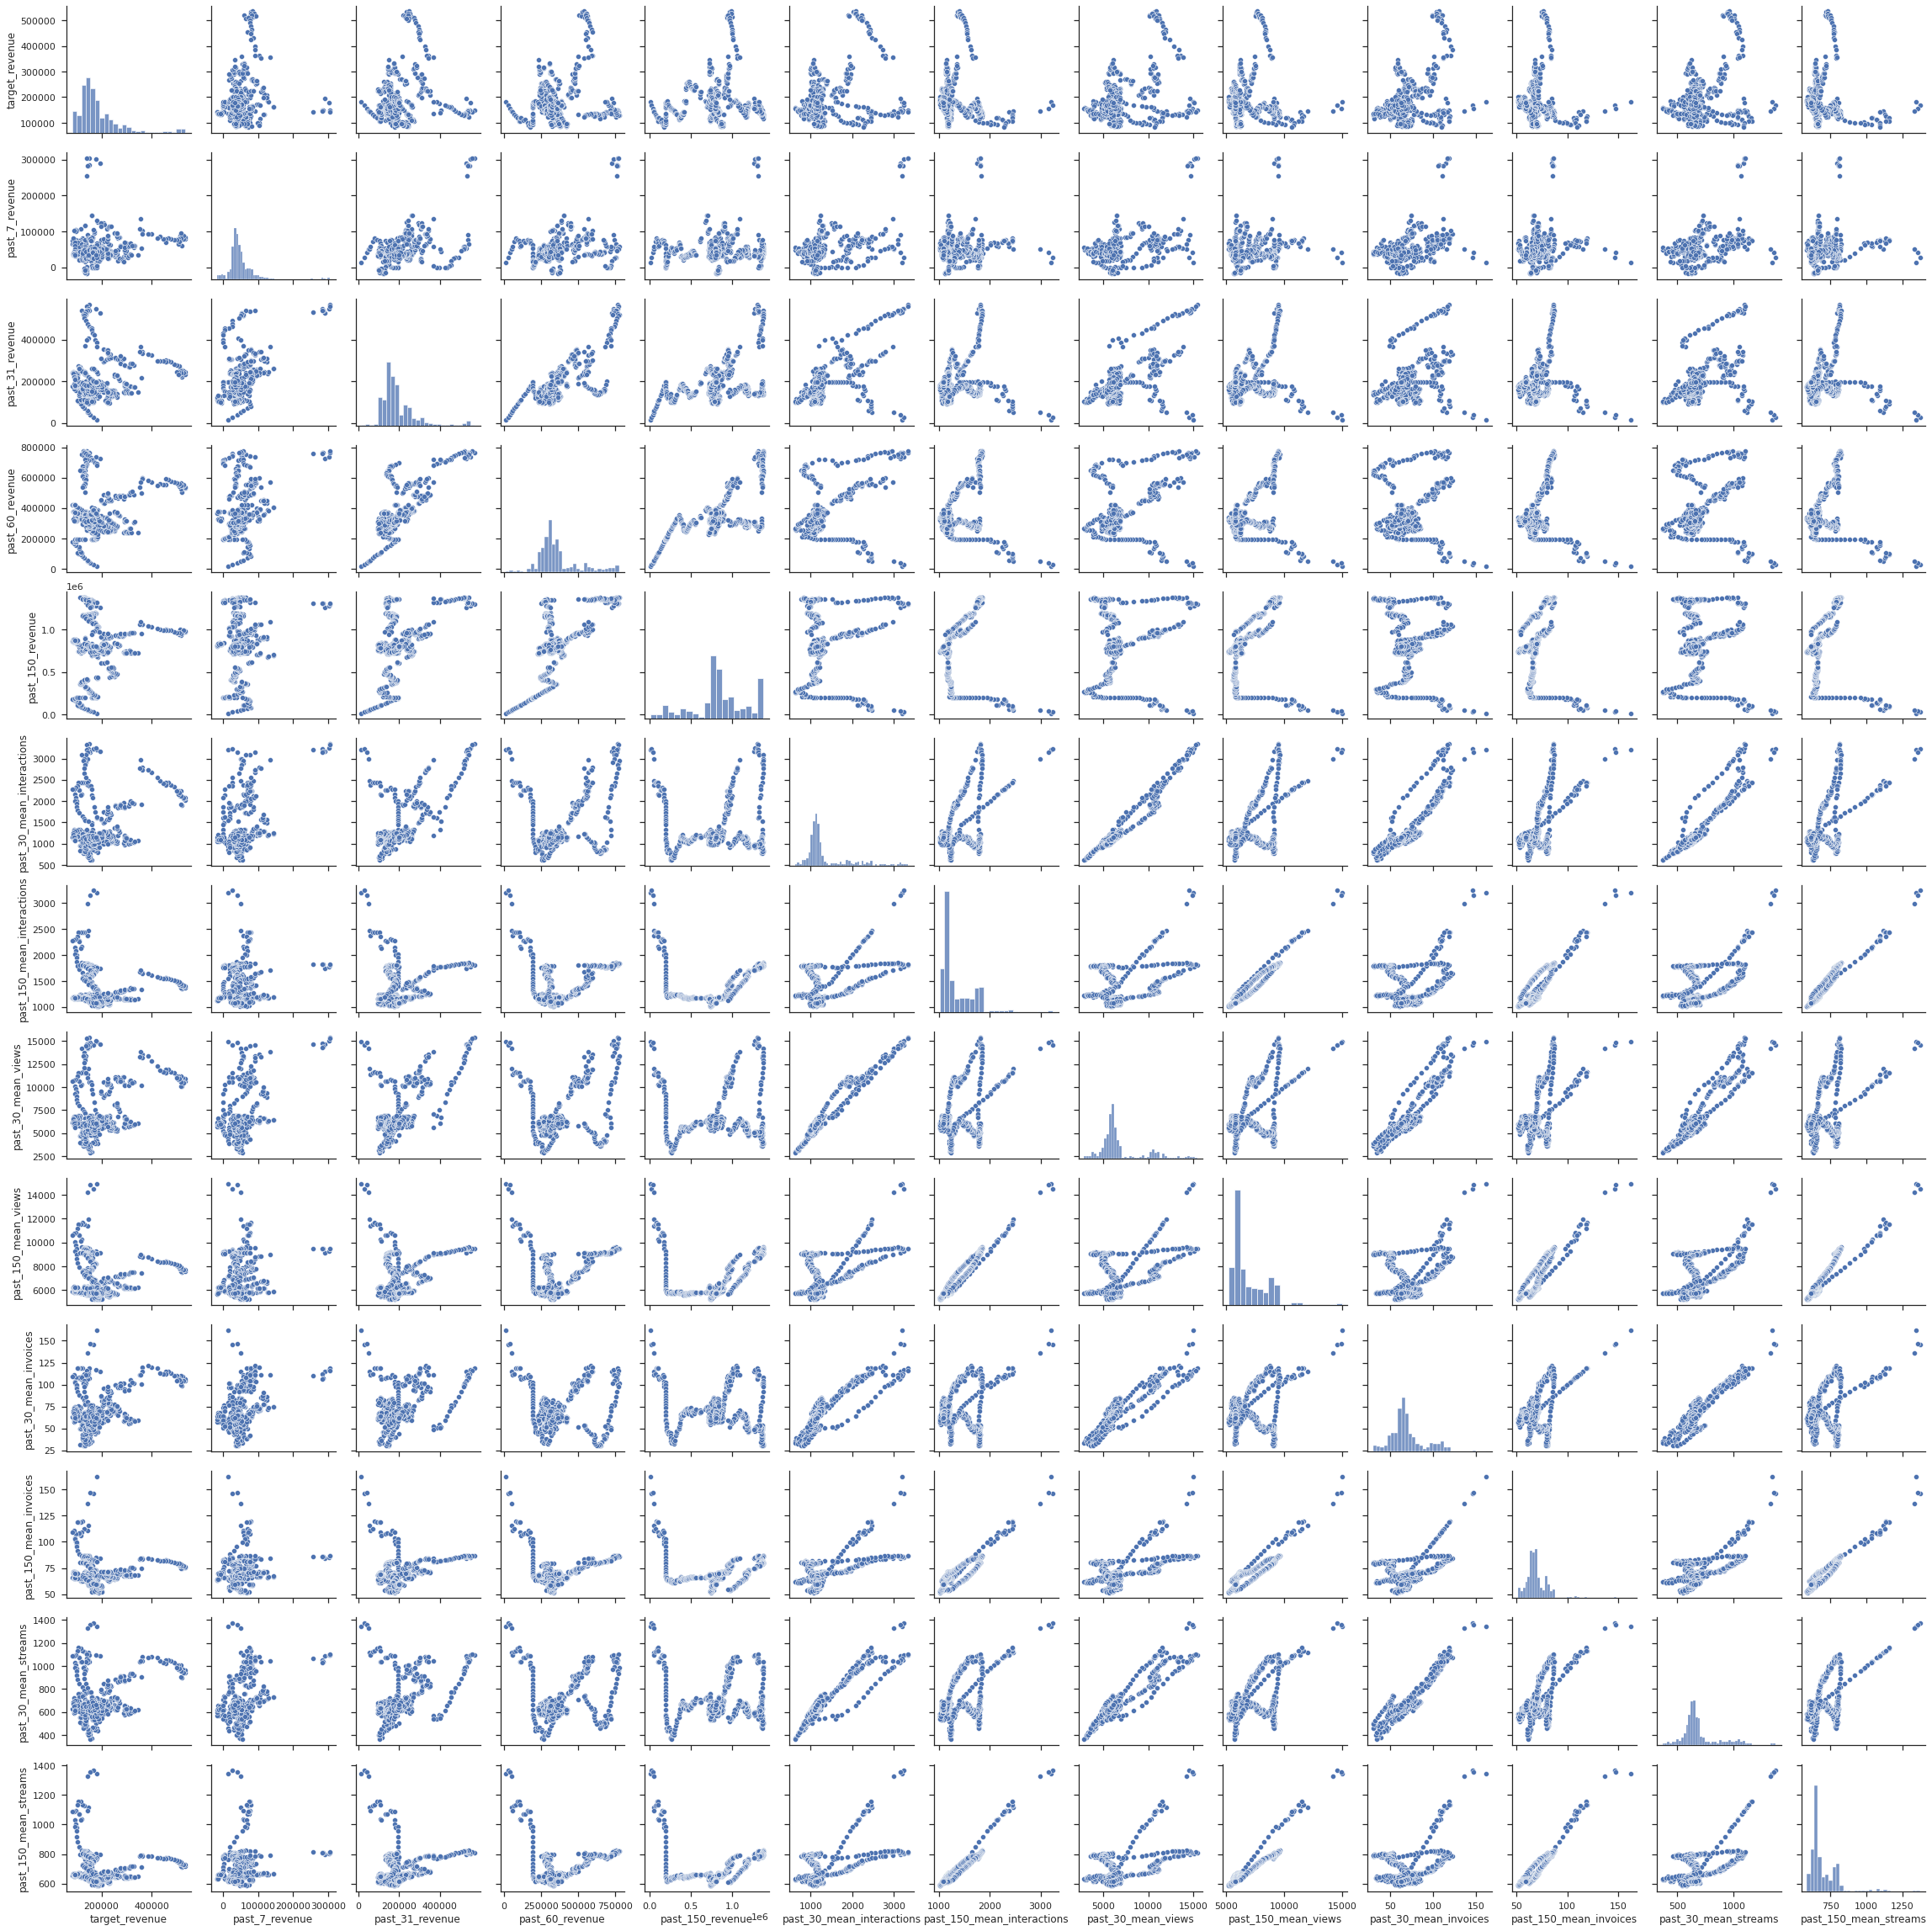

In [11]:
sns.set(style="ticks", color_codes=True)

axes = sns.pairplot(tts,palette="husl")

./images/feature-engineer-corr-grid.png created.


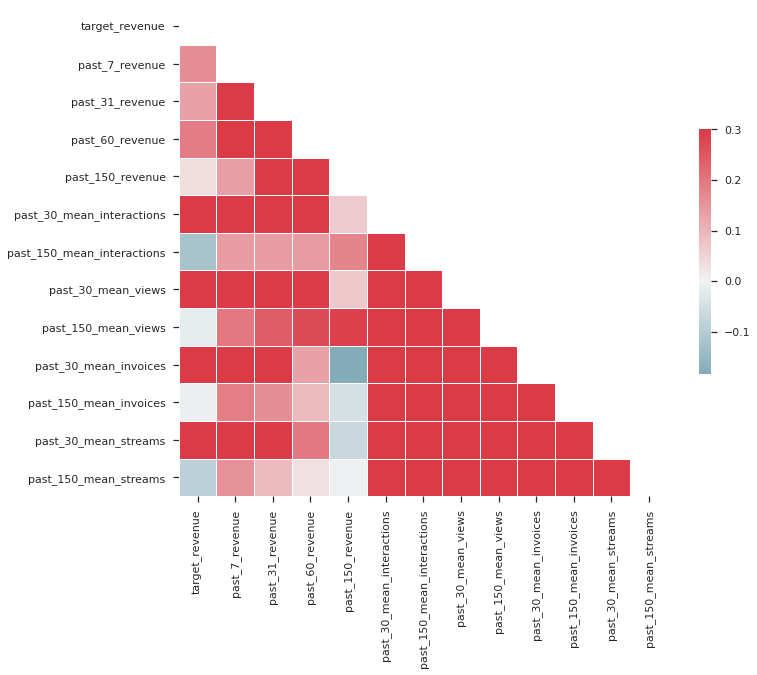

In [12]:
vis.corr_heatmap(tts, "feature-engineer-corr-grid.png")

